# lesson 07: CNNs

This lesson is based on Walter de Back's [2-convolution.ipynb](https://gitlab.com/wdeback/dl-keras-tutorial/-/blob/master/notebooks/2-convolution.ipynb) and [3-cnn-mnist.ipynb](https://gitlab.com/wdeback/dl-keras-tutorial/-/blob/master/notebooks/3-cnn-mnist.ipynb).

## Ingredients of convolutionary filters

The basic ingredients of convolutionary neural networks (CNNs) are:

1. **convolution** filters
2. non-linear **activation**
3. **pooling** operation

We'll leave the non-linear activation for the next session on neural nets. 

Here, we'll focus on the image processing operations: convolution and pooling. 


In [9]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import scipy as sp 

from scipy.ndimage.filters import convolve
from skimage import data

plt.rcParams['image.cmap'] = 'viridis'
plt.style.use('dark_background')

## What is convolution?

- Convolution is the application of a filter over an image. 
- convolution transforms the input image into a different image
- this output image is called a feature map

![](http://i.stack.imgur.com/GvsBA.jpg)


To illustrate what convolution is, let's

1. get an input image and
2. define some handcrafted convolution filters

and apply these filters on the input image.

(-0.5, 383.5, 302.5, -0.5)

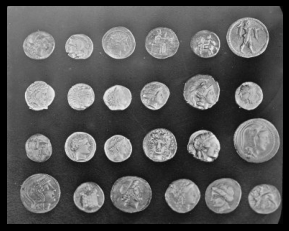

In [10]:
# feel free to experiment with different input images
# that are provided by scikit-image

#im = data.checkerboard()
#im = data.astronaut()
#im = data.rocket()
im = data.coins()

if im.ndim == 3:
    im = np.mean(im, axis=2)
im = np.asarray(im, dtype=np.float32)
plt.imshow(im, cmap='gray')
plt.axis('off')

**(Handcrafted) convolution filters**

In [11]:
cross =  [[-1,1,-1],
          [1,1,1],
          [-1,1,-1]]

sobel1 = [[1,0,-1],
          [2,0,-2],
          [1,0,-1]]

sobel2 = np.array(sobel1).T

emboss = [[-1,-1, 0],
          [-1, 0, 1],
          [ 0, 1, 1]]

sharpen =[[-1,-1,-1],
          [-1, 9,-1],
          [-1,-1,-1]]

sharpen =[[ 1, 1, 1],
          [ 1, -7, 1],
          [ 1, 1, 1]]

mean    =[[ 1, 1, 1],
          [ 1, 1, 1],
          [ 1, 1, 1]]


In [12]:
im1 = convolve(im, cross)
im2 = convolve(im, sobel2)
im3 = convolve(im, sobel1)
im4 = convolve(im, emboss)
im5 = convolve(im, sharpen)
im6 = convolve(im, mean)

In [13]:
def plot_kernel(kernel, ax, label):
    ax.imshow(kernel)
    for (j,i),text in np.ndenumerate(kernel):
        ax.text(i,j,int(text),ha='center',va='center',fontsize=14, color='w')
        ax.text(i,j,int(text),ha='center',va='center',fontsize=14, color='w')
    ax.set_title(label)
    ax.axis('off')
    
def plot_feature_map(image, ax, label):
    ax.imshow(image, cmap='gray')
    ax.set_title(label)
    ax.axis('off')

Show the convolution filter and the image after application of the filter.

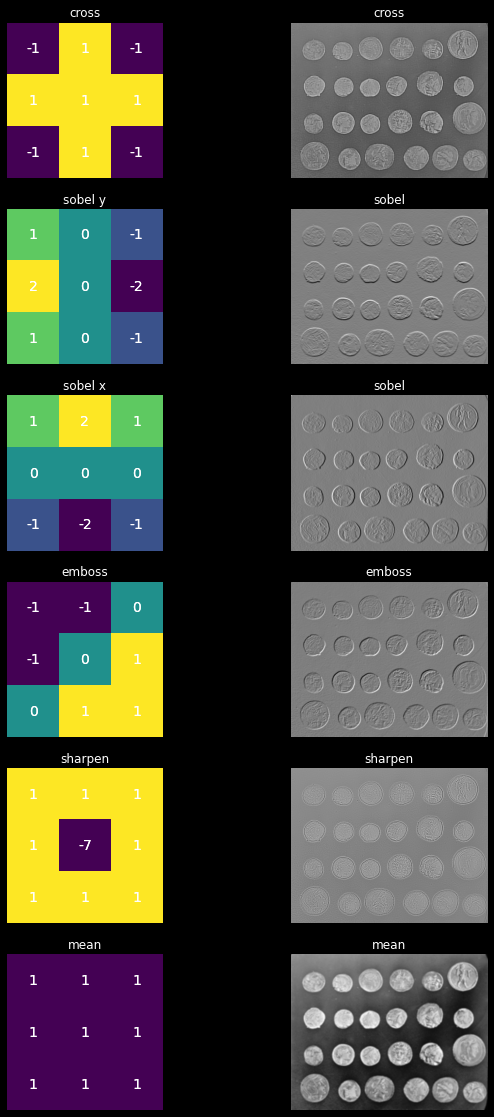

In [14]:
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(10,20))#, sharex=True, sharey=True)

plot_kernel(cross,   ax[0,0], 'cross')
plot_kernel(sobel2,  ax[2,0], 'sobel x') #published in 1968, see https://en.wikipedia.org/wiki/Sobel_operator
plot_kernel(sobel1,  ax[1,0], 'sobel y') #published in 1968, see https://en.wikipedia.org/wiki/Sobel_operator
plot_kernel(emboss,  ax[3,0], 'emboss')
plot_kernel(sharpen, ax[4,0], 'sharpen')
plot_kernel(mean,    ax[5,0], 'mean')

plot_feature_map(im1, ax[0,1], 'cross')
plot_feature_map(im2, ax[1,1], 'sobel')
plot_feature_map(im3, ax[2,1], 'sobel')
plot_feature_map(im4, ax[3,1], 'emboss')
plot_feature_map(im5, ax[4,1], 'sharpen')
plot_feature_map(im6, ax[5,1], 'mean')

## Random filters
- As you can see, convolution filters are useful to extract features from images, e.g. Sobel filters can detect edges. 

- however, we often do not know in advance what features we'd like to extract. 

- Instead, we'd like to **learn** to extract useful features according to a number of examples, using convolutional neural networks (CNNs). 


- In CNNs, instead of handcrafted convolution filters (aka kernels), we **learn** the values (aka kernel weights) of the filters to detect particular features. 

- Before learning, the kernels are typically set to random values.

- below, we generate 25 random kernels and show their resulting feature maps. This is identical to what the first layer in an unlearned convnet with 25 `3x3` kernels does.

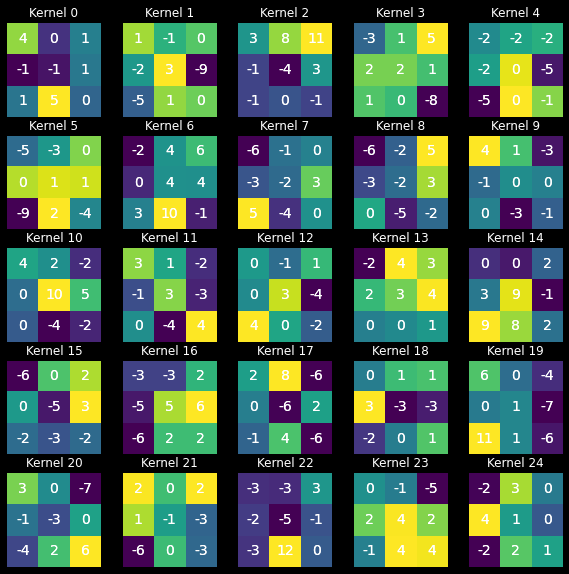

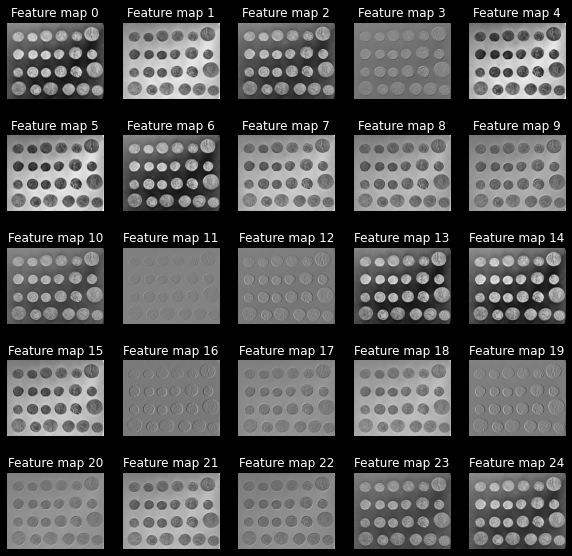

In [15]:
n = 25
nr = int(np.ceil(np.sqrt(n)))
fig1, ax1 = plt.subplots(nrows=nr, ncols=nr, figsize=(10,10), sharex=True, sharey=True)
ax1 = ax1.flatten()
fig2, ax2 = plt.subplots(nrows=nr, ncols=nr, figsize=(10,10), sharex=True, sharey=True)
ax2 = ax2.flatten()


for i in range(n):
    rand_kernel = np.random.normal(loc=0.0, scale=4.0, size=[3,3])
    plot_kernel(rand_kernel, ax1[i], 'Kernel {}'.format(i))

    image = convolve(im, rand_kernel)
    plot_feature_map(image, ax2[i],'Feature map {}'.format(i))
    
    # store images as feature maps
    try:
        feature_maps = np.dstack([feature_maps, image])
    except:
        feature_maps = image


## Pooling

- If we forget about the activation layer for the moment, another common layer type are pooling layers, typically `MaxPooling`. 

- Pooling downsamples the feature maps by taking the local mean `AveragePooling` or maximum `MaxPooling` of each feature map. 

- For purpose of illustration, we take the maximum of each 8x8 block (in CNNs, 2x2 pooling is most often used).

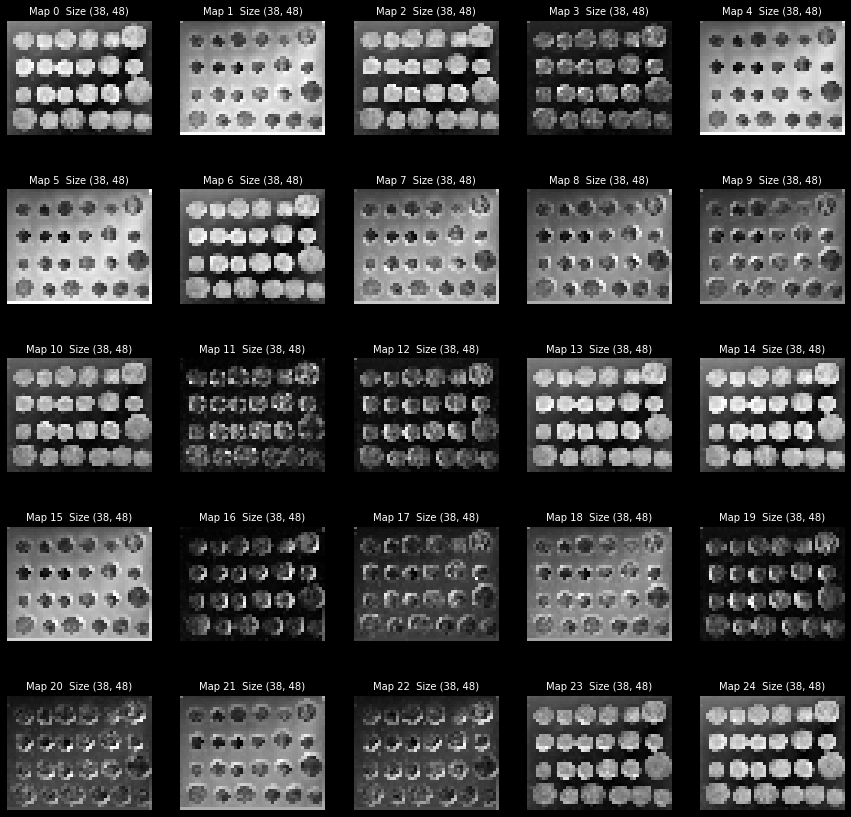

In [16]:
# size of pool blocks
pool_size = (8,8)

def pooling(image, size=(2,2), mode='max'):
    from skimage.measure import block_reduce
    if mode == 'mean':
        return block_reduce(image, block_size=size, func=np.mean)
    else: #mode == 'max':
        return block_reduce(image, block_size=size, func=np.max)

fig, ax = plt.subplots(nrows=nr, ncols=nr, figsize=(15,15), sharex=True, sharey=True)
ax = ax.flatten()
for i in range(n):
    pooled = pooling(feature_maps[:,:,i], pool_size)
    ax[i].imshow(pooled, cmap='gray')
    ax[i].set_title('Map {}  Size {}'.format(i, pooled.shape), fontsize=10)
    ax[i].axis('off')



# Training a convolution neural network to classify handwritten numbers

Trains a simple convnet on the MNIST dataset.

In [17]:
# %matplotlib inline
# import matplotlib.pylab as plt
# plt.style.use('dark_background')
# import numpy as np


Import modules from keras. 

As before, we will use a model with a `Dense` layer. Additionally, however, we are going to use the 2D convolutional layers `Conv2D` and `MaxPooling2D`.

We will use the mnist dataset.

In [29]:
from tensorflow import keras
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.datasets import mnist
from keras.utils import to_categorical

## Preparing the data

__Loading the image data__

The image data will be imported as tensors of shape: NUM x WIDTH x HEIGHT.

The labels will be imported as tensors of shape: NUM x 1


In [30]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("full dataset")
print(x_train.shape)
print(y_train.shape)

num_classes = 10

# to save time, we will only use the first 15% of the data
fraction = 0.15
cut = int(x_train.shape[0]*fraction)
x_train = x_train[:cut]
y_train = y_train[:cut]
cut = int(x_test.shape[0]*fraction)
x_test = x_test[:cut]
y_test = y_test[:cut]

# input image dimensions
img_rows, img_cols = x_train.shape[1:]
print('img_rows = {}, img_cols = {}'.format(img_rows, img_cols))
print('retaining {} training and {} test images'.format(x_train.shape[0], x_test.shape[0]))

full dataset
(60000, 28, 28)
(60000,)
img_rows = 28, img_cols = 28
retaining 9000 training and 1500 test images


Plot some samples from the image data set with titles showing the ground truth labels


5


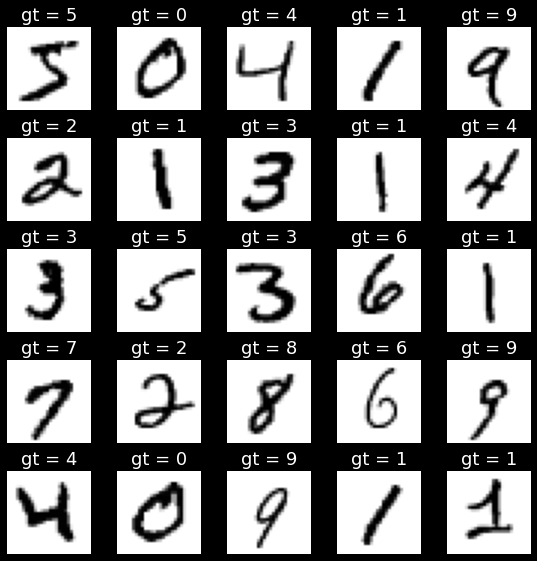

In [31]:
def plot_images(images, labels, gt=None):
    # reduce empty dimensions, if any
    images = np.squeeze(images)
    labels = np.squeeze(labels)
    numrows=int(np.ceil(np.sqrt(images.shape[0])))
    print(numrows)
    fig, axes = plt.subplots(nrows=numrows, ncols=numrows, figsize=(8,8), sharex=True, sharey=True)
    fig.tight_layout()
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap=plt.get_cmap('gray_r'))
        ax.set_title('gt = {}'.format(labels[i]), fontsize=18)
        ax.axis('off')
        
        # highlight wrong predictions is gt (ground truth) is provided
        if gt is not None:
            if gt[i] != labels[i]:
                ax.imshow(images[i], cmap=plt.get_cmap('viridis'))
                ax.set_title('{}≠{}'.format(labels[i], gt[i]), fontsize=18, fontdict={'color':'red'})

plot_images(x_train[:25], y_train[:25])

We must be careful about the format in which we should provide our data to the network.

If you use Tensorflow as a backend (as we are doing here), the image data should be provided in a format with the channels (e.g. RGB) as last dimension:

_NUM x WIDTH x HEIGHT x CHANNELS_ (NWHC)

Pytorch currently also uses this convention. Beware of alternative frameworks which use other conventions to represent images.



In [32]:
#Although we are dealing with grayscale image data and only have a single channel,
#we still need to add a dimension for the channels to obtain a 4D input tensor.
X_train = np.expand_dims(x_train, 3)
X_test = np.expand_dims(x_test, 3)
print('New shape: {}'.format(X_train.shape))

New shape: (9000, 28, 28, 1)


__Preprocessing__

We will convert from uint8 to float encoding and scale the values in our image to lie between 0 and 1.
This is typically done across the ML community as some activation functions expose problems when ingesting too small (vanishing gradients) or too high weights (exploding gradients).

In [33]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255.
X_test /= 255.

print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples',X_train.mean())
print(X_test.shape[0], 'test samples',X_test.mean())

x_train shape: (9000, 28, 28, 1)
9000 train samples 0.13141398
1500 test samples 0.12173627


__One-hot encoding__

We need to convert the labels using the one-hot encoding scheme

In [34]:
# convert class vectors to binary class matrices
Y_train = to_categorical(y_train, num_classes)
Y_test = to_categorical(y_test, num_classes)

# Define a convolutional neural network


In [37]:
## Convolutional part

# conv layer with 32 3x3 filters and retified linear activation units
# Note: first layer requires the specification of an input shape
conv1 = Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:])
# conv layer with 64 3x3 filters and retified linear activation units
conv2 = Conv2D(32, kernel_size=(3, 3), strides=(2,2), activation='relu')
# max pooling with size 2x2
mpool = MaxPooling2D(pool_size=(2, 2))

# dropout layer
# model.add(Dropout(0.25))

## Multilayer perceptron (MLP) part

# first, we need to flatten the output of the conv to obtain a vector
flat = Flatten()

# add a dense NN layer (= fully connected layer of neurons) with ReLU activation
dense1 = Dense(128, activation='relu')
# dropout layer
dropout = Dropout(0.5)
# final layer is equal to the number of classes and uses SoftMax activation
dense2 = Dense(num_classes, activation='softmax')



In [39]:
#let's build up the computational graph
x_inputs = layers.Input(shape=X_train.shape[1:])

## conv layers
x = conv1(x_inputs)
x = conv2(x)
x = mpool(x)

## mlp layers
x = flat(x)
x = dense1(x)
x = dropout(x)
output_yhat = dense2(x)

model = keras.Model(inputs = x_inputs, outputs = output_yhat, name="hello-world-cnn")

__Compile the network__

To compile the network, we need to choose a loss function and an optimizer. 

In [41]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "hello-world-cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               147584    
_________________________________________________________________
dropout (Dropout)            (None, 128)           

# Train the neural network

In [43]:
batch_size = 128
epochs = 12

In [44]:

history = model.fit(X_train, Y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(X_test, Y_test))

Epoch 1/12


 1/71 [..............................] - ETA: 0s - loss: 2.3133 - accuracy: 0.0781

 2/71 [..............................] - ETA: 2s - loss: 2.3022 - accuracy: 0.1094

 3/71 [>.............................] - ETA: 2s - loss: 2.2972 - accuracy: 0.1250

 5/71 [=>............................] - ETA: 2s - loss: 2.2768 - accuracy: 0.1766

 6/71 [=>............................] - ETA: 2s - loss: 2.2646 - accuracy: 0.2044

 7/71 [=>............................] - ETA: 3s - loss: 2.2490 - accuracy: 0.2321

 8/71 [==>...........................] - ETA: 3s - loss: 2.2384 - accuracy: 0.2539

 9/71 [==>...........................] - ETA: 3s - loss: 2.2284 - accuracy: 0.2639

10/71 [===>..........................] - ETA: 3s - loss: 2.2124 - accuracy: 0.2789

11/71 [===>..........................] - ETA: 3s - loss: 2.1961 - accuracy: 0.2955

12/71 [====>.........................] - ETA: 3s - loss: 2.1804 - accuracy: 0.3053

13/71 [====>.........................] - ETA: 3s - loss: 2.1642 - accuracy: 0.3227

14/71 [====>.........................] - ETA: 3s - loss: 2.1466 - accuracy: 0.3376

16/71 [=====>........................] - ETA: 3s - loss: 2.1076 - accuracy: 0.3667

17/71 [======>.......................] - ETA: 2s - loss: 2.0835 - accuracy: 0.3782

19/71 [=======>......................] - ETA: 2s - loss: 2.0363 - accuracy: 0.3993

21/71 [=======>......................] - ETA: 2s - loss: 1.9892 - accuracy: 0.4144

23/71 [========>.....................] - ETA: 2s - loss: 1.9400 - accuracy: 0.4283

25/71 [=========>....................] - ETA: 2s - loss: 1.8816 - accuracy: 0.4453

27/71 [==========>...................] - ETA: 2s - loss: 1.8381 - accuracy: 0.4566

29/71 [===========>..................] - ETA: 1s - loss: 1.7884 - accuracy: 0.4714

30/71 [===========>..................] - ETA: 1s - loss: 1.7666 - accuracy: 0.4766

32/71 [============>.................] - ETA: 1s - loss: 1.7128 - accuracy: 0.4917

34/71 [=============>................] - ETA: 1s - loss: 1.6694 - accuracy: 0.5021

36/71 [==============>...............] - ETA: 1s - loss: 1.6296 - accuracy: 0.5137

37/71 [==============>...............] - ETA: 1s - loss: 1.6094 - accuracy: 0.5188

38/71 [===============>..............] - ETA: 1s - loss: 1.5833 - accuracy: 0.5267

39/71 [===============>..............] - ETA: 1s - loss: 1.5690 - accuracy: 0.5298

41/71 [================>.............] - ETA: 1s - loss: 1.5350 - accuracy: 0.5391

42/71 [================>.............] - ETA: 1s - loss: 1.5193 - accuracy: 0.5432

43/71 [=================>............] - ETA: 1s - loss: 1.5052 - accuracy: 0.5465

45/71 [==================>...........] - ETA: 1s - loss: 1.4736 - accuracy: 0.5538

47/71 [==================>...........] - ETA: 1s - loss: 1.4391 - accuracy: 0.5638

48/71 [===================>..........] - ETA: 1s - loss: 1.4229 - accuracy: 0.5685

49/71 [===================>..........] - ETA: 1s - loss: 1.4077 - accuracy: 0.5722

50/71 [====================>.........] - ETA: 1s - loss: 1.3934 - accuracy: 0.5766

51/71 [====================>.........] - ETA: 0s - loss: 1.3815 - accuracy: 0.5784

52/71 [====================>.........] - ETA: 0s - loss: 1.3701 - accuracy: 0.5807

53/71 [=====================>........] - ETA: 0s - loss: 1.3573 - accuracy: 0.5842

54/71 [=====================>........] - ETA: 0s - loss: 1.3429 - accuracy: 0.5880

56/71 [======================>.......] - ETA: 0s - loss: 1.3159 - accuracy: 0.5957

57/71 [=======================>......] - ETA: 0s - loss: 1.3043 - accuracy: 0.5984

58/71 [=======================>......] - ETA: 0s - loss: 1.2916 - accuracy: 0.6021

59/71 [=======================>......] - ETA: 0s - loss: 1.2797 - accuracy: 0.6055

60/71 [========================>.....] - ETA: 0s - loss: 1.2673 - accuracy: 0.6090

61/71 [========================>.....] - ETA: 0s - loss: 1.2570 - accuracy: 0.6123

62/71 [=========================>....] - ETA: 0s - loss: 1.2467 - accuracy: 0.6158

63/71 [=========================>....] - ETA: 0s - loss: 1.2373 - accuracy: 0.6187

64/71 [==========================>...] - ETA: 0s - loss: 1.2277 - accuracy: 0.6217

65/71 [==========================>...] - ETA: 0s - loss: 1.2147 - accuracy: 0.6255

66/71 [==========================>...] - ETA: 0s - loss: 1.2067 - accuracy: 0.6278

67/71 [===========================>..] - ETA: 0s - loss: 1.1953 - accuracy: 0.6315

68/71 [===========================>..] - ETA: 0s - loss: 1.1861 - accuracy: 0.6338

69/71 [============================>.] - ETA: 0s - loss: 1.1758 - accuracy: 0.6369

71/71 [==============================] - ETA: 0s - loss: 1.1656 - accuracy: 0.6402

71/71 [==============================] - 4s 60ms/step - loss: 1.1656 - accuracy: 0.6402 - val_loss: 0.4798 - val_accuracy: 0.8607


Epoch 2/12
 1/71 [..............................] - ETA: 0s - loss: 0.5858 - accuracy: 0.8594

 2/71 [..............................] - ETA: 2s - loss: 0.5399 - accuracy: 0.8516

 3/71 [>.............................] - ETA: 3s - loss: 0.5644 - accuracy: 0.8307

 5/71 [=>............................] - ETA: 2s - loss: 0.5931 - accuracy: 0.8234

 6/71 [=>............................] - ETA: 2s - loss: 0.6039 - accuracy: 0.8203

 7/71 [=>............................] - ETA: 3s - loss: 0.6041 - accuracy: 0.8281

 9/71 [==>...........................] - ETA: 2s - loss: 0.5840 - accuracy: 0.8247

10/71 [===>..........................] - ETA: 2s - loss: 0.5677 - accuracy: 0.8297

11/71 [===>..........................] - ETA: 2s - loss: 0.5624 - accuracy: 0.8331

13/71 [====>.........................] - ETA: 2s - loss: 0.5653 - accuracy: 0.8317

14/71 [====>.........................] - ETA: 2s - loss: 0.5525 - accuracy: 0.8359

15/71 [=====>........................] - ETA: 2s - loss: 0.5446 - accuracy: 0.8380

16/71 [=====>........................] - ETA: 2s - loss: 0.5379 - accuracy: 0.8389

17/71 [======>.......................] - ETA: 2s - loss: 0.5319 - accuracy: 0.8396

18/71 [======>.......................] - ETA: 2s - loss: 0.5269 - accuracy: 0.8411

19/71 [=======>......................] - ETA: 2s - loss: 0.5249 - accuracy: 0.8405

21/71 [=======>......................] - ETA: 2s - loss: 0.5091 - accuracy: 0.8475

22/71 [========>.....................] - ETA: 2s - loss: 0.5132 - accuracy: 0.8469

24/71 [=========>....................] - ETA: 2s - loss: 0.5088 - accuracy: 0.8490

25/71 [=========>....................] - ETA: 2s - loss: 0.5162 - accuracy: 0.8481

26/71 [=========>....................] - ETA: 2s - loss: 0.5142 - accuracy: 0.8477

28/71 [==========>...................] - ETA: 2s - loss: 0.5095 - accuracy: 0.8479

29/71 [===========>..................] - ETA: 2s - loss: 0.5053 - accuracy: 0.8491

30/71 [===========>..................] - ETA: 2s - loss: 0.5035 - accuracy: 0.8490

31/71 [============>.................] - ETA: 2s - loss: 0.4982 - accuracy: 0.8495

32/71 [============>.................] - ETA: 2s - loss: 0.4985 - accuracy: 0.8481

34/71 [=============>................] - ETA: 2s - loss: 0.4993 - accuracy: 0.8488

35/71 [=============>................] - ETA: 2s - loss: 0.4959 - accuracy: 0.8498

36/71 [==============>...............] - ETA: 2s - loss: 0.4919 - accuracy: 0.8507

37/71 [==============>...............] - ETA: 1s - loss: 0.4909 - accuracy: 0.8522

39/71 [===============>..............] - ETA: 1s - loss: 0.4908 - accuracy: 0.8510

41/71 [================>.............] - ETA: 1s - loss: 0.4865 - accuracy: 0.8508

42/71 [================>.............] - ETA: 1s - loss: 0.4813 - accuracy: 0.8516

43/71 [=================>............] - ETA: 1s - loss: 0.4812 - accuracy: 0.8523

44/71 [=================>............] - ETA: 1s - loss: 0.4829 - accuracy: 0.8507

45/71 [==================>...........] - ETA: 1s - loss: 0.4796 - accuracy: 0.8517

46/71 [==================>...........] - ETA: 1s - loss: 0.4778 - accuracy: 0.8526

47/71 [==================>...........] - ETA: 1s - loss: 0.4758 - accuracy: 0.8536

48/71 [===================>..........] - ETA: 1s - loss: 0.4755 - accuracy: 0.8532

49/71 [===================>..........] - ETA: 1s - loss: 0.4759 - accuracy: 0.8533

50/71 [====================>.........] - ETA: 1s - loss: 0.4733 - accuracy: 0.8542

51/71 [====================>.........] - ETA: 1s - loss: 0.4730 - accuracy: 0.8551

52/71 [====================>.........] - ETA: 1s - loss: 0.4720 - accuracy: 0.8558

54/71 [=====================>........] - ETA: 1s - loss: 0.4679 - accuracy: 0.8565

56/71 [======================>.......] - ETA: 0s - loss: 0.4673 - accuracy: 0.8566

58/71 [=======================>......] - ETA: 0s - loss: 0.4645 - accuracy: 0.8571

60/71 [========================>.....] - ETA: 0s - loss: 0.4642 - accuracy: 0.8581

62/71 [=========================>....] - ETA: 0s - loss: 0.4620 - accuracy: 0.8581

63/71 [=========================>....] - ETA: 0s - loss: 0.4615 - accuracy: 0.8578

64/71 [==========================>...] - ETA: 0s - loss: 0.4609 - accuracy: 0.8579

66/71 [==========================>...] - ETA: 0s - loss: 0.4575 - accuracy: 0.8584

67/71 [===========================>..] - ETA: 0s - loss: 0.4538 - accuracy: 0.8597

68/71 [===========================>..] - ETA: 0s - loss: 0.4552 - accuracy: 0.8595

70/71 [============================>.] - ETA: 0s - loss: 0.4510 - accuracy: 0.8607

71/71 [==============================] - ETA: 0s - loss: 0.4503 - accuracy: 0.8609

71/71 [==============================] - 4s 60ms/step - loss: 0.4503 - accuracy: 0.8609 - val_loss: 0.2998 - val_accuracy: 0.9020


Epoch 3/12
 1/71 [..............................] - ETA: 0s - loss: 0.4089 - accuracy: 0.8594

 2/71 [..............................] - ETA: 2s - loss: 0.3935 - accuracy: 0.8828

 3/71 [>.............................] - ETA: 2s - loss: 0.3603 - accuracy: 0.8854

 4/71 [>.............................] - ETA: 2s - loss: 0.3424 - accuracy: 0.8945

 6/71 [=>............................] - ETA: 2s - loss: 0.3241 - accuracy: 0.9023

 8/71 [==>...........................] - ETA: 2s - loss: 0.3270 - accuracy: 0.9023

 9/71 [==>...........................] - ETA: 2s - loss: 0.3293 - accuracy: 0.8993

10/71 [===>..........................] - ETA: 2s - loss: 0.3432 - accuracy: 0.8969

11/71 [===>..........................] - ETA: 2s - loss: 0.3464 - accuracy: 0.8956

12/71 [====>.........................] - ETA: 2s - loss: 0.3404 - accuracy: 0.8965

13/71 [====>.........................] - ETA: 2s - loss: 0.3342 - accuracy: 0.8984

15/71 [=====>........................] - ETA: 2s - loss: 0.3424 - accuracy: 0.8953

16/71 [=====>........................] - ETA: 2s - loss: 0.3492 - accuracy: 0.8936

17/71 [======>.......................] - ETA: 2s - loss: 0.3514 - accuracy: 0.8925

18/71 [======>.......................] - ETA: 2s - loss: 0.3462 - accuracy: 0.8937

19/71 [=======>......................] - ETA: 2s - loss: 0.3444 - accuracy: 0.8923

20/71 [=======>......................] - ETA: 2s - loss: 0.3435 - accuracy: 0.8934

21/71 [=======>......................] - ETA: 2s - loss: 0.3411 - accuracy: 0.8951

22/71 [========>.....................] - ETA: 2s - loss: 0.3402 - accuracy: 0.8967

23/71 [========>.....................] - ETA: 2s - loss: 0.3432 - accuracy: 0.8957

24/71 [=========>....................] - ETA: 2s - loss: 0.3407 - accuracy: 0.8945

25/71 [=========>....................] - ETA: 2s - loss: 0.3377 - accuracy: 0.8959

26/71 [=========>....................] - ETA: 2s - loss: 0.3394 - accuracy: 0.8966

27/71 [==========>...................] - ETA: 2s - loss: 0.3434 - accuracy: 0.8953

28/71 [==========>...................] - ETA: 2s - loss: 0.3420 - accuracy: 0.8965

29/71 [===========>..................] - ETA: 2s - loss: 0.3383 - accuracy: 0.8976

30/71 [===========>..................] - ETA: 2s - loss: 0.3370 - accuracy: 0.8982

31/71 [============>.................] - ETA: 2s - loss: 0.3361 - accuracy: 0.8987

33/71 [============>.................] - ETA: 2s - loss: 0.3364 - accuracy: 0.9001

35/71 [=============>................] - ETA: 2s - loss: 0.3310 - accuracy: 0.9018

36/71 [==============>...............] - ETA: 2s - loss: 0.3332 - accuracy: 0.9000

37/71 [==============>...............] - ETA: 2s - loss: 0.3314 - accuracy: 0.9008

39/71 [===============>..............] - ETA: 1s - loss: 0.3299 - accuracy: 0.9012

41/71 [================>.............] - ETA: 1s - loss: 0.3276 - accuracy: 0.9024

43/71 [=================>............] - ETA: 1s - loss: 0.3229 - accuracy: 0.9035

45/71 [==================>...........] - ETA: 1s - loss: 0.3210 - accuracy: 0.9033

46/71 [==================>...........] - ETA: 1s - loss: 0.3212 - accuracy: 0.9030

47/71 [==================>...........] - ETA: 1s - loss: 0.3233 - accuracy: 0.9031

48/71 [===================>..........] - ETA: 1s - loss: 0.3228 - accuracy: 0.9030

49/71 [===================>..........] - ETA: 1s - loss: 0.3236 - accuracy: 0.9029

50/71 [====================>.........] - ETA: 1s - loss: 0.3254 - accuracy: 0.9030

51/71 [====================>.........] - ETA: 1s - loss: 0.3248 - accuracy: 0.9032

52/71 [====================>.........] - ETA: 1s - loss: 0.3242 - accuracy: 0.9035

53/71 [=====================>........] - ETA: 1s - loss: 0.3224 - accuracy: 0.9040

54/71 [=====================>........] - ETA: 1s - loss: 0.3230 - accuracy: 0.9039

55/71 [======================>.......] - ETA: 0s - loss: 0.3200 - accuracy: 0.9050

56/71 [======================>.......] - ETA: 0s - loss: 0.3183 - accuracy: 0.9058

57/71 [=======================>......] - ETA: 0s - loss: 0.3187 - accuracy: 0.9065

58/71 [=======================>......] - ETA: 0s - loss: 0.3199 - accuracy: 0.9060

59/71 [=======================>......] - ETA: 0s - loss: 0.3195 - accuracy: 0.9061

60/71 [========================>.....] - ETA: 0s - loss: 0.3170 - accuracy: 0.9070

61/71 [========================>.....] - ETA: 0s - loss: 0.3150 - accuracy: 0.9078

62/71 [=========================>....] - ETA: 0s - loss: 0.3146 - accuracy: 0.9076

63/71 [=========================>....] - ETA: 0s - loss: 0.3126 - accuracy: 0.9084

65/71 [==========================>...] - ETA: 0s - loss: 0.3119 - accuracy: 0.9083

66/71 [==========================>...] - ETA: 0s - loss: 0.3135 - accuracy: 0.9084

68/71 [===========================>..] - ETA: 0s - loss: 0.3128 - accuracy: 0.9082

69/71 [============================>.] - ETA: 0s - loss: 0.3114 - accuracy: 0.9086

71/71 [==============================] - ETA: 0s - loss: 0.3119 - accuracy: 0.9080

71/71 [==============================] - 5s 64ms/step - loss: 0.3119 - accuracy: 0.9080 - val_loss: 0.2178 - val_accuracy: 0.9340


Epoch 4/12
 1/71 [..............................] - ETA: 0s - loss: 0.2583 - accuracy: 0.9219

 3/71 [>.............................] - ETA: 2s - loss: 0.2664 - accuracy: 0.9115

 4/71 [>.............................] - ETA: 2s - loss: 0.3185 - accuracy: 0.8984

 5/71 [=>............................] - ETA: 3s - loss: 0.2867 - accuracy: 0.9078

 6/71 [=>............................] - ETA: 3s - loss: 0.2898 - accuracy: 0.9102

 7/71 [=>............................] - ETA: 3s - loss: 0.2779 - accuracy: 0.9152

 8/71 [==>...........................] - ETA: 4s - loss: 0.2688 - accuracy: 0.9189

 9/71 [==>...........................] - ETA: 3s - loss: 0.2708 - accuracy: 0.9184

10/71 [===>..........................] - ETA: 3s - loss: 0.2711 - accuracy: 0.9164

11/71 [===>..........................] - ETA: 3s - loss: 0.2631 - accuracy: 0.9190

12/71 [====>.........................] - ETA: 3s - loss: 0.2599 - accuracy: 0.9199

13/71 [====>.........................] - ETA: 3s - loss: 0.2582 - accuracy: 0.9201

14/71 [====>.........................] - ETA: 4s - loss: 0.2581 - accuracy: 0.9208

15/71 [=====>........................] - ETA: 3s - loss: 0.2583 - accuracy: 0.9203

16/71 [=====>........................] - ETA: 3s - loss: 0.2638 - accuracy: 0.9189

17/71 [======>.......................] - ETA: 3s - loss: 0.2650 - accuracy: 0.9191

18/71 [======>.......................] - ETA: 3s - loss: 0.2650 - accuracy: 0.9184

19/71 [=======>......................] - ETA: 3s - loss: 0.2693 - accuracy: 0.9161

20/71 [=======>......................] - ETA: 3s - loss: 0.2687 - accuracy: 0.9172

21/71 [=======>......................] - ETA: 3s - loss: 0.2653 - accuracy: 0.9185

22/71 [========>.....................] - ETA: 3s - loss: 0.2619 - accuracy: 0.9194

23/71 [========>.....................] - ETA: 3s - loss: 0.2617 - accuracy: 0.9195

24/71 [=========>....................] - ETA: 3s - loss: 0.2604 - accuracy: 0.9209

25/71 [=========>....................] - ETA: 3s - loss: 0.2611 - accuracy: 0.9206

27/71 [==========>...................] - ETA: 2s - loss: 0.2587 - accuracy: 0.9204

29/71 [===========>..................] - ETA: 2s - loss: 0.2607 - accuracy: 0.9203

30/71 [===========>..................] - ETA: 2s - loss: 0.2663 - accuracy: 0.9201

31/71 [============>.................] - ETA: 2s - loss: 0.2650 - accuracy: 0.9204

32/71 [============>.................] - ETA: 2s - loss: 0.2620 - accuracy: 0.9209

33/71 [============>.................] - ETA: 2s - loss: 0.2610 - accuracy: 0.9214

34/71 [=============>................] - ETA: 2s - loss: 0.2598 - accuracy: 0.9226

35/71 [=============>................] - ETA: 2s - loss: 0.2598 - accuracy: 0.9219

36/71 [==============>...............] - ETA: 2s - loss: 0.2620 - accuracy: 0.9212

37/71 [==============>...............] - ETA: 2s - loss: 0.2620 - accuracy: 0.9212

38/71 [===============>..............] - ETA: 2s - loss: 0.2607 - accuracy: 0.9215

39/71 [===============>..............] - ETA: 2s - loss: 0.2612 - accuracy: 0.9211

41/71 [================>.............] - ETA: 1s - loss: 0.2635 - accuracy: 0.9200

43/71 [=================>............] - ETA: 1s - loss: 0.2622 - accuracy: 0.9210

44/71 [=================>............] - ETA: 1s - loss: 0.2619 - accuracy: 0.9215

45/71 [==================>...........] - ETA: 1s - loss: 0.2600 - accuracy: 0.9219

46/71 [==================>...........] - ETA: 1s - loss: 0.2598 - accuracy: 0.9220

47/71 [==================>...........] - ETA: 1s - loss: 0.2580 - accuracy: 0.9225

48/71 [===================>..........] - ETA: 1s - loss: 0.2591 - accuracy: 0.9222

50/71 [====================>.........] - ETA: 1s - loss: 0.2584 - accuracy: 0.9220

52/71 [====================>.........] - ETA: 1s - loss: 0.2541 - accuracy: 0.9234

53/71 [=====================>........] - ETA: 1s - loss: 0.2542 - accuracy: 0.9236

54/71 [=====================>........] - ETA: 1s - loss: 0.2538 - accuracy: 0.9236

55/71 [======================>.......] - ETA: 1s - loss: 0.2526 - accuracy: 0.9239

56/71 [======================>.......] - ETA: 0s - loss: 0.2507 - accuracy: 0.9244

58/71 [=======================>......] - ETA: 0s - loss: 0.2496 - accuracy: 0.9251

59/71 [=======================>......] - ETA: 0s - loss: 0.2494 - accuracy: 0.9252

60/71 [========================>.....] - ETA: 0s - loss: 0.2501 - accuracy: 0.9251

61/71 [========================>.....] - ETA: 0s - loss: 0.2480 - accuracy: 0.9256

62/71 [=========================>....] - ETA: 0s - loss: 0.2501 - accuracy: 0.9252

63/71 [=========================>....] - ETA: 0s - loss: 0.2494 - accuracy: 0.9253

64/71 [==========================>...] - ETA: 0s - loss: 0.2499 - accuracy: 0.9253

65/71 [==========================>...] - ETA: 0s - loss: 0.2512 - accuracy: 0.9256

66/71 [==========================>...] - ETA: 0s - loss: 0.2503 - accuracy: 0.9258

67/71 [===========================>..] - ETA: 0s - loss: 0.2496 - accuracy: 0.9257

68/71 [===========================>..] - ETA: 0s - loss: 0.2482 - accuracy: 0.9259

69/71 [============================>.] - ETA: 0s - loss: 0.2480 - accuracy: 0.9258

70/71 [============================>.] - ETA: 0s - loss: 0.2472 - accuracy: 0.9260

71/71 [==============================] - ETA: 0s - loss: 0.2474 - accuracy: 0.9258

71/71 [==============================] - 5s 73ms/step - loss: 0.2474 - accuracy: 0.9258 - val_loss: 0.1807 - val_accuracy: 0.9427


Epoch 5/12
 1/71 [..............................] - ETA: 0s - loss: 0.2137 - accuracy: 0.9531

 2/71 [..............................] - ETA: 3s - loss: 0.2123 - accuracy: 0.9414

 3/71 [>.............................] - ETA: 4s - loss: 0.2145 - accuracy: 0.9349

 4/71 [>.............................] - ETA: 4s - loss: 0.2025 - accuracy: 0.9375

 5/71 [=>............................] - ETA: 4s - loss: 0.2051 - accuracy: 0.9297

 6/71 [=>............................] - ETA: 5s - loss: 0.2031 - accuracy: 0.9297

 7/71 [=>............................] - ETA: 4s - loss: 0.1926 - accuracy: 0.9364

 8/71 [==>...........................] - ETA: 4s - loss: 0.1882 - accuracy: 0.9375

 9/71 [==>...........................] - ETA: 4s - loss: 0.2041 - accuracy: 0.9332

11/71 [===>..........................] - ETA: 4s - loss: 0.2014 - accuracy: 0.9332

12/71 [====>.........................] - ETA: 4s - loss: 0.2024 - accuracy: 0.9342

13/71 [====>.........................] - ETA: 4s - loss: 0.2145 - accuracy: 0.9327

15/71 [=====>........................] - ETA: 3s - loss: 0.2185 - accuracy: 0.9344

16/71 [=====>........................] - ETA: 3s - loss: 0.2165 - accuracy: 0.9360

17/71 [======>.......................] - ETA: 3s - loss: 0.2123 - accuracy: 0.9375

19/71 [=======>......................] - ETA: 3s - loss: 0.2102 - accuracy: 0.9400

20/71 [=======>......................] - ETA: 3s - loss: 0.2104 - accuracy: 0.9414

21/71 [=======>......................] - ETA: 3s - loss: 0.2111 - accuracy: 0.9420

23/71 [========>.....................] - ETA: 2s - loss: 0.2115 - accuracy: 0.9423

24/71 [=========>....................] - ETA: 2s - loss: 0.2129 - accuracy: 0.9424

26/71 [=========>....................] - ETA: 2s - loss: 0.2085 - accuracy: 0.9429

27/71 [==========>...................] - ETA: 2s - loss: 0.2148 - accuracy: 0.9410

28/71 [==========>...................] - ETA: 2s - loss: 0.2148 - accuracy: 0.9403

30/71 [===========>..................] - ETA: 2s - loss: 0.2139 - accuracy: 0.9404

32/71 [============>.................] - ETA: 2s - loss: 0.2142 - accuracy: 0.9414

33/71 [============>.................] - ETA: 2s - loss: 0.2118 - accuracy: 0.9418

34/71 [=============>................] - ETA: 2s - loss: 0.2107 - accuracy: 0.9416

36/71 [==============>...............] - ETA: 1s - loss: 0.2092 - accuracy: 0.9425

37/71 [==============>...............] - ETA: 1s - loss: 0.2086 - accuracy: 0.9428

38/71 [===============>..............] - ETA: 1s - loss: 0.2071 - accuracy: 0.9431

39/71 [===============>..............] - ETA: 1s - loss: 0.2079 - accuracy: 0.9427

41/71 [================>.............] - ETA: 1s - loss: 0.2076 - accuracy: 0.9426

42/71 [================>.............] - ETA: 1s - loss: 0.2069 - accuracy: 0.9429

43/71 [=================>............] - ETA: 1s - loss: 0.2065 - accuracy: 0.9430

44/71 [=================>............] - ETA: 1s - loss: 0.2048 - accuracy: 0.9435

45/71 [==================>...........] - ETA: 1s - loss: 0.2046 - accuracy: 0.9436

46/71 [==================>...........] - ETA: 1s - loss: 0.2042 - accuracy: 0.9436

47/71 [==================>...........] - ETA: 1s - loss: 0.2031 - accuracy: 0.9437

48/71 [===================>..........] - ETA: 1s - loss: 0.2046 - accuracy: 0.9427

50/71 [====================>.........] - ETA: 1s - loss: 0.2035 - accuracy: 0.9431

51/71 [====================>.........] - ETA: 1s - loss: 0.2035 - accuracy: 0.9427

52/71 [====================>.........] - ETA: 1s - loss: 0.2041 - accuracy: 0.9426

53/71 [=====================>........] - ETA: 1s - loss: 0.2039 - accuracy: 0.9427

54/71 [=====================>........] - ETA: 1s - loss: 0.2030 - accuracy: 0.9426

55/71 [======================>.......] - ETA: 0s - loss: 0.2041 - accuracy: 0.9420

56/71 [======================>.......] - ETA: 0s - loss: 0.2066 - accuracy: 0.9414

57/71 [=======================>......] - ETA: 0s - loss: 0.2062 - accuracy: 0.9415

58/71 [=======================>......] - ETA: 0s - loss: 0.2047 - accuracy: 0.9419

59/71 [=======================>......] - ETA: 0s - loss: 0.2034 - accuracy: 0.9421

60/71 [========================>.....] - ETA: 0s - loss: 0.2032 - accuracy: 0.9422

61/71 [========================>.....] - ETA: 0s - loss: 0.2033 - accuracy: 0.9419

62/71 [=========================>....] - ETA: 0s - loss: 0.2036 - accuracy: 0.9417

63/71 [=========================>....] - ETA: 0s - loss: 0.2028 - accuracy: 0.9417

64/71 [==========================>...] - ETA: 0s - loss: 0.2042 - accuracy: 0.9412

66/71 [==========================>...] - ETA: 0s - loss: 0.2038 - accuracy: 0.9413

67/71 [===========================>..] - ETA: 0s - loss: 0.2035 - accuracy: 0.9411

68/71 [===========================>..] - ETA: 0s - loss: 0.2035 - accuracy: 0.9413

69/71 [============================>.] - ETA: 0s - loss: 0.2035 - accuracy: 0.9410

70/71 [============================>.] - ETA: 0s - loss: 0.2025 - accuracy: 0.9411

71/71 [==============================] - 5s 69ms/step - loss: 0.2024 - accuracy: 0.9410 - val_loss: 0.1717 - val_accuracy: 0.9447


Epoch 6/12
 1/71 [..............................] - ETA: 0s - loss: 0.1742 - accuracy: 0.9609

 2/71 [..............................] - ETA: 3s - loss: 0.1373 - accuracy: 0.9727

 3/71 [>.............................] - ETA: 3s - loss: 0.1635 - accuracy: 0.9635

 4/71 [>.............................] - ETA: 4s - loss: 0.1709 - accuracy: 0.9570

 5/71 [=>............................] - ETA: 4s - loss: 0.1615 - accuracy: 0.9594

 6/71 [=>............................] - ETA: 4s - loss: 0.1810 - accuracy: 0.9466

 7/71 [=>............................] - ETA: 4s - loss: 0.1788 - accuracy: 0.9442

 8/71 [==>...........................] - ETA: 3s - loss: 0.1875 - accuracy: 0.9434

 9/71 [==>...........................] - ETA: 3s - loss: 0.1950 - accuracy: 0.9401

10/71 [===>..........................] - ETA: 3s - loss: 0.1961 - accuracy: 0.9398

11/71 [===>..........................] - ETA: 3s - loss: 0.1893 - accuracy: 0.9425

12/71 [====>.........................] - ETA: 3s - loss: 0.1956 - accuracy: 0.9382

13/71 [====>.........................] - ETA: 3s - loss: 0.1999 - accuracy: 0.9375

14/71 [====>.........................] - ETA: 3s - loss: 0.2057 - accuracy: 0.9369

15/71 [=====>........................] - ETA: 3s - loss: 0.2020 - accuracy: 0.9375

16/71 [=====>........................] - ETA: 3s - loss: 0.2038 - accuracy: 0.9370

18/71 [======>.......................] - ETA: 3s - loss: 0.1955 - accuracy: 0.9405

19/71 [=======>......................] - ETA: 3s - loss: 0.1923 - accuracy: 0.9420

20/71 [=======>......................] - ETA: 3s - loss: 0.1908 - accuracy: 0.9438

21/71 [=======>......................] - ETA: 3s - loss: 0.1909 - accuracy: 0.9435

22/71 [========>.....................] - ETA: 3s - loss: 0.1892 - accuracy: 0.9435

23/71 [========>.....................] - ETA: 3s - loss: 0.1886 - accuracy: 0.9433

24/71 [=========>....................] - ETA: 3s - loss: 0.1879 - accuracy: 0.9434

25/71 [=========>....................] - ETA: 3s - loss: 0.1901 - accuracy: 0.9422

26/71 [=========>....................] - ETA: 3s - loss: 0.1886 - accuracy: 0.9432

27/71 [==========>...................] - ETA: 3s - loss: 0.1902 - accuracy: 0.9427

28/71 [==========>...................] - ETA: 3s - loss: 0.1904 - accuracy: 0.9436

29/71 [===========>..................] - ETA: 3s - loss: 0.1914 - accuracy: 0.9432

30/71 [===========>..................] - ETA: 3s - loss: 0.1945 - accuracy: 0.9422

31/71 [============>.................] - ETA: 3s - loss: 0.1945 - accuracy: 0.9418

32/71 [============>.................] - ETA: 3s - loss: 0.1936 - accuracy: 0.9421

33/71 [============>.................] - ETA: 3s - loss: 0.1929 - accuracy: 0.9422

34/71 [=============>................] - ETA: 2s - loss: 0.1904 - accuracy: 0.9428

35/71 [=============>................] - ETA: 2s - loss: 0.1927 - accuracy: 0.9424

36/71 [==============>...............] - ETA: 2s - loss: 0.1909 - accuracy: 0.9425

37/71 [==============>...............] - ETA: 2s - loss: 0.1923 - accuracy: 0.9421

38/71 [===============>..............] - ETA: 2s - loss: 0.1934 - accuracy: 0.9418

39/71 [===============>..............] - ETA: 2s - loss: 0.1929 - accuracy: 0.9421

40/71 [===============>..............] - ETA: 2s - loss: 0.1920 - accuracy: 0.9418

41/71 [================>.............] - ETA: 2s - loss: 0.1916 - accuracy: 0.9409

42/71 [================>.............] - ETA: 2s - loss: 0.1920 - accuracy: 0.9408

43/71 [=================>............] - ETA: 2s - loss: 0.1914 - accuracy: 0.9402

44/71 [=================>............] - ETA: 2s - loss: 0.1905 - accuracy: 0.9402

45/71 [==================>...........] - ETA: 2s - loss: 0.1891 - accuracy: 0.9408

46/71 [==================>...........] - ETA: 2s - loss: 0.1893 - accuracy: 0.9409

47/71 [==================>...........] - ETA: 1s - loss: 0.1874 - accuracy: 0.9417

48/71 [===================>..........] - ETA: 1s - loss: 0.1882 - accuracy: 0.9414

49/71 [===================>..........] - ETA: 1s - loss: 0.1872 - accuracy: 0.9415

50/71 [====================>.........] - ETA: 1s - loss: 0.1877 - accuracy: 0.9417

51/71 [====================>.........] - ETA: 1s - loss: 0.1860 - accuracy: 0.9422

52/71 [====================>.........] - ETA: 1s - loss: 0.1841 - accuracy: 0.9428

53/71 [=====================>........] - ETA: 1s - loss: 0.1848 - accuracy: 0.9425

54/71 [=====================>........] - ETA: 1s - loss: 0.1845 - accuracy: 0.9423

55/71 [======================>.......] - ETA: 1s - loss: 0.1840 - accuracy: 0.9422

56/71 [======================>.......] - ETA: 1s - loss: 0.1856 - accuracy: 0.9420

57/71 [=======================>......] - ETA: 1s - loss: 0.1859 - accuracy: 0.9420

58/71 [=======================>......] - ETA: 1s - loss: 0.1868 - accuracy: 0.9415

59/71 [=======================>......] - ETA: 0s - loss: 0.1868 - accuracy: 0.9413

60/71 [========================>.....] - ETA: 0s - loss: 0.1858 - accuracy: 0.9415

61/71 [========================>.....] - ETA: 0s - loss: 0.1844 - accuracy: 0.9419

62/71 [=========================>....] - ETA: 0s - loss: 0.1848 - accuracy: 0.9415

63/71 [=========================>....] - ETA: 0s - loss: 0.1849 - accuracy: 0.9416

64/71 [==========================>...] - ETA: 0s - loss: 0.1843 - accuracy: 0.9421

66/71 [==========================>...] - ETA: 0s - loss: 0.1845 - accuracy: 0.9422

67/71 [===========================>..] - ETA: 0s - loss: 0.1834 - accuracy: 0.9425

68/71 [===========================>..] - ETA: 0s - loss: 0.1838 - accuracy: 0.9423

69/71 [============================>.] - ETA: 0s - loss: 0.1856 - accuracy: 0.9421

71/71 [==============================] - ETA: 0s - loss: 0.1860 - accuracy: 0.9421

71/71 [==============================] - 6s 82ms/step - loss: 0.1860 - accuracy: 0.9421 - val_loss: 0.1388 - val_accuracy: 0.9547


Epoch 7/12


 1/71 [..............................] - ETA: 0s - loss: 0.1576 - accuracy: 0.9219

 2/71 [..............................] - ETA: 2s - loss: 0.1390 - accuracy: 0.9336

 3/71 [>.............................] - ETA: 2s - loss: 0.1579 - accuracy: 0.9323

 4/71 [>.............................] - ETA: 3s - loss: 0.1693 - accuracy: 0.9336

 5/71 [=>............................] - ETA: 3s - loss: 0.1802 - accuracy: 0.9312

 6/71 [=>............................] - ETA: 3s - loss: 0.1836 - accuracy: 0.9284

 7/71 [=>............................] - ETA: 3s - loss: 0.1824 - accuracy: 0.9308

 8/71 [==>...........................] - ETA: 3s - loss: 0.1695 - accuracy: 0.9365

10/71 [===>..........................] - ETA: 3s - loss: 0.1745 - accuracy: 0.9359

11/71 [===>..........................] - ETA: 3s - loss: 0.1761 - accuracy: 0.9382

12/71 [====>.........................] - ETA: 3s - loss: 0.1706 - accuracy: 0.9408

13/71 [====>.........................] - ETA: 3s - loss: 0.1661 - accuracy: 0.9429

15/71 [=====>........................] - ETA: 3s - loss: 0.1676 - accuracy: 0.9438

16/71 [=====>........................] - ETA: 3s - loss: 0.1647 - accuracy: 0.9448

17/71 [======>.......................] - ETA: 3s - loss: 0.1677 - accuracy: 0.9444

18/71 [======>.......................] - ETA: 3s - loss: 0.1701 - accuracy: 0.9440

20/71 [=======>......................] - ETA: 3s - loss: 0.1697 - accuracy: 0.9449

21/71 [=======>......................] - ETA: 3s - loss: 0.1722 - accuracy: 0.9453

22/71 [========>.....................] - ETA: 3s - loss: 0.1692 - accuracy: 0.9471

24/71 [=========>....................] - ETA: 2s - loss: 0.1709 - accuracy: 0.9463

26/71 [=========>....................] - ETA: 2s - loss: 0.1687 - accuracy: 0.9471

28/71 [==========>...................] - ETA: 2s - loss: 0.1662 - accuracy: 0.9481

29/71 [===========>..................] - ETA: 2s - loss: 0.1633 - accuracy: 0.9494

31/71 [============>.................] - ETA: 2s - loss: 0.1625 - accuracy: 0.9493

33/71 [============>.................] - ETA: 2s - loss: 0.1614 - accuracy: 0.9493

35/71 [=============>................] - ETA: 2s - loss: 0.1624 - accuracy: 0.9491

36/71 [==============>...............] - ETA: 2s - loss: 0.1642 - accuracy: 0.9484

38/71 [===============>..............] - ETA: 1s - loss: 0.1661 - accuracy: 0.9474

39/71 [===============>..............] - ETA: 1s - loss: 0.1667 - accuracy: 0.9473

40/71 [===============>..............] - ETA: 1s - loss: 0.1679 - accuracy: 0.9475

41/71 [================>.............] - ETA: 1s - loss: 0.1685 - accuracy: 0.9472

42/71 [================>.............] - ETA: 1s - loss: 0.1709 - accuracy: 0.9470

43/71 [=================>............] - ETA: 1s - loss: 0.1704 - accuracy: 0.9473

44/71 [=================>............] - ETA: 1s - loss: 0.1702 - accuracy: 0.9471

45/71 [==================>...........] - ETA: 1s - loss: 0.1720 - accuracy: 0.9465

46/71 [==================>...........] - ETA: 1s - loss: 0.1721 - accuracy: 0.9465

47/71 [==================>...........] - ETA: 1s - loss: 0.1719 - accuracy: 0.9465

48/71 [===================>..........] - ETA: 1s - loss: 0.1737 - accuracy: 0.9460

49/71 [===================>..........] - ETA: 1s - loss: 0.1719 - accuracy: 0.9466

50/71 [====================>.........] - ETA: 1s - loss: 0.1707 - accuracy: 0.9472

52/71 [====================>.........] - ETA: 1s - loss: 0.1685 - accuracy: 0.9480

53/71 [=====================>........] - ETA: 1s - loss: 0.1670 - accuracy: 0.9483

54/71 [=====================>........] - ETA: 1s - loss: 0.1658 - accuracy: 0.9488

55/71 [======================>.......] - ETA: 1s - loss: 0.1661 - accuracy: 0.9486

56/71 [======================>.......] - ETA: 0s - loss: 0.1660 - accuracy: 0.9487

57/71 [=======================>......] - ETA: 0s - loss: 0.1664 - accuracy: 0.9489

58/71 [=======================>......] - ETA: 0s - loss: 0.1660 - accuracy: 0.9487

59/71 [=======================>......] - ETA: 0s - loss: 0.1661 - accuracy: 0.9486

60/71 [========================>.....] - ETA: 0s - loss: 0.1656 - accuracy: 0.9487

61/71 [========================>.....] - ETA: 0s - loss: 0.1640 - accuracy: 0.9493

62/71 [=========================>....] - ETA: 0s - loss: 0.1628 - accuracy: 0.9496

63/71 [=========================>....] - ETA: 0s - loss: 0.1618 - accuracy: 0.9500

64/71 [==========================>...] - ETA: 0s - loss: 0.1625 - accuracy: 0.9500

65/71 [==========================>...] - ETA: 0s - loss: 0.1616 - accuracy: 0.9500

66/71 [==========================>...] - ETA: 0s - loss: 0.1608 - accuracy: 0.9500

67/71 [===========================>..] - ETA: 0s - loss: 0.1606 - accuracy: 0.9499

68/71 [===========================>..] - ETA: 0s - loss: 0.1599 - accuracy: 0.9500

69/71 [============================>.] - ETA: 0s - loss: 0.1612 - accuracy: 0.9502

70/71 [============================>.] - ETA: 0s - loss: 0.1612 - accuracy: 0.9501

71/71 [==============================] - ETA: 0s - loss: 0.1609 - accuracy: 0.9502

71/71 [==============================] - 5s 69ms/step - loss: 0.1609 - accuracy: 0.9502 - val_loss: 0.1226 - val_accuracy: 0.9560


Epoch 8/12
 1/71 [..............................] - ETA: 0s - loss: 0.1662 - accuracy: 0.9531

 3/71 [>.............................] - ETA: 2s - loss: 0.1444 - accuracy: 0.9661

 4/71 [>.............................] - ETA: 3s - loss: 0.1441 - accuracy: 0.9609

 7/71 [=>............................] - ETA: 2s - loss: 0.1480 - accuracy: 0.9598

 8/71 [==>...........................] - ETA: 2s - loss: 0.1463 - accuracy: 0.9600

 9/71 [==>...........................] - ETA: 2s - loss: 0.1387 - accuracy: 0.9618

10/71 [===>..........................] - ETA: 2s - loss: 0.1450 - accuracy: 0.9609

12/71 [====>.........................] - ETA: 2s - loss: 0.1459 - accuracy: 0.9603

13/71 [====>.........................] - ETA: 2s - loss: 0.1467 - accuracy: 0.9603

14/71 [====>.........................] - ETA: 2s - loss: 0.1535 - accuracy: 0.9576

15/71 [=====>........................] - ETA: 2s - loss: 0.1514 - accuracy: 0.9573

17/71 [======>.......................] - ETA: 2s - loss: 0.1474 - accuracy: 0.9568

19/71 [=======>......................] - ETA: 2s - loss: 0.1502 - accuracy: 0.9548

20/71 [=======>......................] - ETA: 2s - loss: 0.1476 - accuracy: 0.9547

22/71 [========>.....................] - ETA: 2s - loss: 0.1444 - accuracy: 0.9556

23/71 [========>.....................] - ETA: 2s - loss: 0.1437 - accuracy: 0.9548

24/71 [=========>....................] - ETA: 2s - loss: 0.1452 - accuracy: 0.9548

26/71 [=========>....................] - ETA: 2s - loss: 0.1455 - accuracy: 0.9552

27/71 [==========>...................] - ETA: 2s - loss: 0.1461 - accuracy: 0.9552

28/71 [==========>...................] - ETA: 2s - loss: 0.1492 - accuracy: 0.9542

29/71 [===========>..................] - ETA: 2s - loss: 0.1493 - accuracy: 0.9547

30/71 [===========>..................] - ETA: 2s - loss: 0.1479 - accuracy: 0.9549

32/71 [============>.................] - ETA: 2s - loss: 0.1454 - accuracy: 0.9551

33/71 [============>.................] - ETA: 2s - loss: 0.1454 - accuracy: 0.9548

34/71 [=============>................] - ETA: 2s - loss: 0.1442 - accuracy: 0.9554

35/71 [=============>................] - ETA: 2s - loss: 0.1426 - accuracy: 0.9558

36/71 [==============>...............] - ETA: 2s - loss: 0.1418 - accuracy: 0.9557

37/71 [==============>...............] - ETA: 1s - loss: 0.1418 - accuracy: 0.9559

38/71 [===============>..............] - ETA: 1s - loss: 0.1408 - accuracy: 0.9558

39/71 [===============>..............] - ETA: 1s - loss: 0.1410 - accuracy: 0.9557

40/71 [===============>..............] - ETA: 1s - loss: 0.1397 - accuracy: 0.9563

41/71 [================>.............] - ETA: 1s - loss: 0.1397 - accuracy: 0.9566

42/71 [================>.............] - ETA: 1s - loss: 0.1405 - accuracy: 0.9561

44/71 [=================>............] - ETA: 1s - loss: 0.1408 - accuracy: 0.9563

45/71 [==================>...........] - ETA: 1s - loss: 0.1393 - accuracy: 0.9568

46/71 [==================>...........] - ETA: 1s - loss: 0.1403 - accuracy: 0.9564

47/71 [==================>...........] - ETA: 1s - loss: 0.1396 - accuracy: 0.9568

48/71 [===================>..........] - ETA: 1s - loss: 0.1375 - accuracy: 0.9575

49/71 [===================>..........] - ETA: 1s - loss: 0.1386 - accuracy: 0.9574

50/71 [====================>.........] - ETA: 1s - loss: 0.1382 - accuracy: 0.9578

51/71 [====================>.........] - ETA: 1s - loss: 0.1370 - accuracy: 0.9583

52/71 [====================>.........] - ETA: 1s - loss: 0.1366 - accuracy: 0.9581

53/71 [=====================>........] - ETA: 1s - loss: 0.1355 - accuracy: 0.9584

54/71 [=====================>........] - ETA: 1s - loss: 0.1342 - accuracy: 0.9588

55/71 [======================>.......] - ETA: 1s - loss: 0.1339 - accuracy: 0.9582

56/71 [======================>.......] - ETA: 0s - loss: 0.1339 - accuracy: 0.9584

57/71 [=======================>......] - ETA: 0s - loss: 0.1338 - accuracy: 0.9585

58/71 [=======================>......] - ETA: 0s - loss: 0.1354 - accuracy: 0.9580

59/71 [=======================>......] - ETA: 0s - loss: 0.1344 - accuracy: 0.9584

60/71 [========================>.....] - ETA: 0s - loss: 0.1358 - accuracy: 0.9579

61/71 [========================>.....] - ETA: 0s - loss: 0.1354 - accuracy: 0.9581

62/71 [=========================>....] - ETA: 0s - loss: 0.1356 - accuracy: 0.9580

63/71 [=========================>....] - ETA: 0s - loss: 0.1345 - accuracy: 0.9585

65/71 [==========================>...] - ETA: 0s - loss: 0.1343 - accuracy: 0.9583

66/71 [==========================>...] - ETA: 0s - loss: 0.1355 - accuracy: 0.9580

67/71 [===========================>..] - ETA: 0s - loss: 0.1372 - accuracy: 0.9572

68/71 [===========================>..] - ETA: 0s - loss: 0.1375 - accuracy: 0.9570

69/71 [============================>.] - ETA: 0s - loss: 0.1374 - accuracy: 0.9572

70/71 [============================>.] - ETA: 0s - loss: 0.1367 - accuracy: 0.9575

71/71 [==============================] - 5s 69ms/step - loss: 0.1381 - accuracy: 0.9571 - val_loss: 0.1296 - val_accuracy: 0.9560


Epoch 9/12
 1/71 [..............................] - ETA: 0s - loss: 0.0919 - accuracy: 0.9688

 2/71 [..............................] - ETA: 2s - loss: 0.0954 - accuracy: 0.9727

 3/71 [>.............................] - ETA: 3s - loss: 0.0839 - accuracy: 0.9766

 4/71 [>.............................] - ETA: 3s - loss: 0.0785 - accuracy: 0.9824

 5/71 [=>............................] - ETA: 4s - loss: 0.0893 - accuracy: 0.9766

 6/71 [=>............................] - ETA: 3s - loss: 0.0992 - accuracy: 0.9727

 7/71 [=>............................] - ETA: 3s - loss: 0.1132 - accuracy: 0.9654

 8/71 [==>...........................] - ETA: 3s - loss: 0.1165 - accuracy: 0.9609

 9/71 [==>...........................] - ETA: 3s - loss: 0.1186 - accuracy: 0.9609

10/71 [===>..........................] - ETA: 3s - loss: 0.1258 - accuracy: 0.9609

11/71 [===>..........................] - ETA: 3s - loss: 0.1252 - accuracy: 0.9616

13/71 [====>.........................] - ETA: 3s - loss: 0.1265 - accuracy: 0.9597

14/71 [====>.........................] - ETA: 3s - loss: 0.1270 - accuracy: 0.9587

15/71 [=====>........................] - ETA: 3s - loss: 0.1239 - accuracy: 0.9599

16/71 [=====>........................] - ETA: 3s - loss: 0.1256 - accuracy: 0.9600

17/71 [======>.......................] - ETA: 3s - loss: 0.1286 - accuracy: 0.9577

18/71 [======>.......................] - ETA: 3s - loss: 0.1306 - accuracy: 0.9579

19/71 [=======>......................] - ETA: 3s - loss: 0.1314 - accuracy: 0.9576

20/71 [=======>......................] - ETA: 3s - loss: 0.1331 - accuracy: 0.9582

21/71 [=======>......................] - ETA: 3s - loss: 0.1332 - accuracy: 0.9587

23/71 [========>.....................] - ETA: 2s - loss: 0.1279 - accuracy: 0.9606

24/71 [=========>....................] - ETA: 2s - loss: 0.1288 - accuracy: 0.9606

25/71 [=========>....................] - ETA: 2s - loss: 0.1341 - accuracy: 0.9584

26/71 [=========>....................] - ETA: 2s - loss: 0.1310 - accuracy: 0.9594

27/71 [==========>...................] - ETA: 2s - loss: 0.1302 - accuracy: 0.9601

28/71 [==========>...................] - ETA: 2s - loss: 0.1323 - accuracy: 0.9593

29/71 [===========>..................] - ETA: 2s - loss: 0.1297 - accuracy: 0.9601

30/71 [===========>..................] - ETA: 2s - loss: 0.1324 - accuracy: 0.9594

31/71 [============>.................] - ETA: 2s - loss: 0.1309 - accuracy: 0.9597

32/71 [============>.................] - ETA: 2s - loss: 0.1286 - accuracy: 0.9604

33/71 [============>.................] - ETA: 2s - loss: 0.1270 - accuracy: 0.9605

34/71 [=============>................] - ETA: 2s - loss: 0.1283 - accuracy: 0.9600

35/71 [=============>................] - ETA: 2s - loss: 0.1273 - accuracy: 0.9605

36/71 [==============>...............] - ETA: 2s - loss: 0.1276 - accuracy: 0.9603

37/71 [==============>...............] - ETA: 2s - loss: 0.1266 - accuracy: 0.9607

38/71 [===============>..............] - ETA: 2s - loss: 0.1259 - accuracy: 0.9611

39/71 [===============>..............] - ETA: 2s - loss: 0.1252 - accuracy: 0.9609

40/71 [===============>..............] - ETA: 2s - loss: 0.1252 - accuracy: 0.9611

41/71 [================>.............] - ETA: 1s - loss: 0.1241 - accuracy: 0.9619

43/71 [=================>............] - ETA: 1s - loss: 0.1254 - accuracy: 0.9618

44/71 [=================>............] - ETA: 1s - loss: 0.1260 - accuracy: 0.9618

45/71 [==================>...........] - ETA: 1s - loss: 0.1263 - accuracy: 0.9616

46/71 [==================>...........] - ETA: 1s - loss: 0.1276 - accuracy: 0.9618

47/71 [==================>...........] - ETA: 1s - loss: 0.1273 - accuracy: 0.9619

48/71 [===================>..........] - ETA: 1s - loss: 0.1270 - accuracy: 0.9619

49/71 [===================>..........] - ETA: 1s - loss: 0.1274 - accuracy: 0.9619

50/71 [====================>.........] - ETA: 1s - loss: 0.1299 - accuracy: 0.9609

51/71 [====================>.........] - ETA: 1s - loss: 0.1306 - accuracy: 0.9603

52/71 [====================>.........] - ETA: 1s - loss: 0.1304 - accuracy: 0.9599

53/71 [=====================>........] - ETA: 1s - loss: 0.1311 - accuracy: 0.9596

55/71 [======================>.......] - ETA: 1s - loss: 0.1300 - accuracy: 0.9602

56/71 [======================>.......] - ETA: 0s - loss: 0.1316 - accuracy: 0.9600

57/71 [=======================>......] - ETA: 0s - loss: 0.1309 - accuracy: 0.9601

58/71 [=======================>......] - ETA: 0s - loss: 0.1300 - accuracy: 0.9604

59/71 [=======================>......] - ETA: 0s - loss: 0.1297 - accuracy: 0.9604

60/71 [========================>.....] - ETA: 0s - loss: 0.1307 - accuracy: 0.9602

61/71 [========================>.....] - ETA: 0s - loss: 0.1314 - accuracy: 0.9602

62/71 [=========================>....] - ETA: 0s - loss: 0.1307 - accuracy: 0.9604

63/71 [=========================>....] - ETA: 0s - loss: 0.1293 - accuracy: 0.9608

64/71 [==========================>...] - ETA: 0s - loss: 0.1297 - accuracy: 0.9607

66/71 [==========================>...] - ETA: 0s - loss: 0.1298 - accuracy: 0.9603

67/71 [===========================>..] - ETA: 0s - loss: 0.1312 - accuracy: 0.9602

69/71 [============================>.] - ETA: 0s - loss: 0.1299 - accuracy: 0.9608

70/71 [============================>.] - ETA: 0s - loss: 0.1317 - accuracy: 0.9604

71/71 [==============================] - 5s 69ms/step - loss: 0.1313 - accuracy: 0.9606 - val_loss: 0.1182 - val_accuracy: 0.9580


Epoch 10/12


 1/71 [..............................] - ETA: 0s - loss: 0.0654 - accuracy: 0.9688

 2/71 [..............................] - ETA: 2s - loss: 0.1120 - accuracy: 0.9570

 3/71 [>.............................] - ETA: 4s - loss: 0.1172 - accuracy: 0.9635

 5/71 [=>............................] - ETA: 3s - loss: 0.1050 - accuracy: 0.9656

 6/71 [=>............................] - ETA: 3s - loss: 0.1053 - accuracy: 0.9648

 8/71 [==>...........................] - ETA: 3s - loss: 0.1096 - accuracy: 0.9648

10/71 [===>..........................] - ETA: 3s - loss: 0.1088 - accuracy: 0.9641

12/71 [====>.........................] - ETA: 2s - loss: 0.1121 - accuracy: 0.9629

13/71 [====>.........................] - ETA: 2s - loss: 0.1109 - accuracy: 0.9627

15/71 [=====>........................] - ETA: 2s - loss: 0.1070 - accuracy: 0.9651

16/71 [=====>........................] - ETA: 2s - loss: 0.1104 - accuracy: 0.9634

18/71 [======>.......................] - ETA: 2s - loss: 0.1080 - accuracy: 0.9635

19/71 [=======>......................] - ETA: 2s - loss: 0.1080 - accuracy: 0.9626

20/71 [=======>......................] - ETA: 2s - loss: 0.1100 - accuracy: 0.9617

22/71 [========>.....................] - ETA: 2s - loss: 0.1086 - accuracy: 0.9631

23/71 [========>.....................] - ETA: 2s - loss: 0.1071 - accuracy: 0.9637

24/71 [=========>....................] - ETA: 2s - loss: 0.1078 - accuracy: 0.9632

25/71 [=========>....................] - ETA: 2s - loss: 0.1092 - accuracy: 0.9628

26/71 [=========>....................] - ETA: 2s - loss: 0.1151 - accuracy: 0.9612

27/71 [==========>...................] - ETA: 2s - loss: 0.1145 - accuracy: 0.9615

28/71 [==========>...................] - ETA: 2s - loss: 0.1131 - accuracy: 0.9618

30/71 [===========>..................] - ETA: 2s - loss: 0.1106 - accuracy: 0.9628

32/71 [============>.................] - ETA: 2s - loss: 0.1103 - accuracy: 0.9634

34/71 [=============>................] - ETA: 1s - loss: 0.1096 - accuracy: 0.9637

35/71 [=============>................] - ETA: 1s - loss: 0.1109 - accuracy: 0.9638

36/71 [==============>...............] - ETA: 1s - loss: 0.1122 - accuracy: 0.9635

38/71 [===============>..............] - ETA: 1s - loss: 0.1134 - accuracy: 0.9634

39/71 [===============>..............] - ETA: 1s - loss: 0.1133 - accuracy: 0.9635

41/71 [================>.............] - ETA: 1s - loss: 0.1170 - accuracy: 0.9625

43/71 [=================>............] - ETA: 1s - loss: 0.1171 - accuracy: 0.9624

45/71 [==================>...........] - ETA: 1s - loss: 0.1161 - accuracy: 0.9623

46/71 [==================>...........] - ETA: 1s - loss: 0.1177 - accuracy: 0.9618

47/71 [==================>...........] - ETA: 1s - loss: 0.1171 - accuracy: 0.9619

48/71 [===================>..........] - ETA: 1s - loss: 0.1166 - accuracy: 0.9624

50/71 [====================>.........] - ETA: 1s - loss: 0.1143 - accuracy: 0.9633

51/71 [====================>.........] - ETA: 1s - loss: 0.1147 - accuracy: 0.9632

52/71 [====================>.........] - ETA: 1s - loss: 0.1163 - accuracy: 0.9629

54/71 [=====================>........] - ETA: 0s - loss: 0.1168 - accuracy: 0.9628

55/71 [======================>.......] - ETA: 0s - loss: 0.1154 - accuracy: 0.9634

56/71 [======================>.......] - ETA: 0s - loss: 0.1153 - accuracy: 0.9633

58/71 [=======================>......] - ETA: 0s - loss: 0.1140 - accuracy: 0.9642

59/71 [=======================>......] - ETA: 0s - loss: 0.1135 - accuracy: 0.9641

61/71 [========================>.....] - ETA: 0s - loss: 0.1112 - accuracy: 0.9650

62/71 [=========================>....] - ETA: 0s - loss: 0.1106 - accuracy: 0.9652

63/71 [=========================>....] - ETA: 0s - loss: 0.1104 - accuracy: 0.9653

64/71 [==========================>...] - ETA: 0s - loss: 0.1102 - accuracy: 0.9653

65/71 [==========================>...] - ETA: 0s - loss: 0.1098 - accuracy: 0.9654

67/71 [===========================>..] - ETA: 0s - loss: 0.1116 - accuracy: 0.9649

68/71 [===========================>..] - ETA: 0s - loss: 0.1119 - accuracy: 0.9646

69/71 [============================>.] - ETA: 0s - loss: 0.1120 - accuracy: 0.9646

70/71 [============================>.] - ETA: 0s - loss: 0.1112 - accuracy: 0.9648

71/71 [==============================] - ETA: 0s - loss: 0.1107 - accuracy: 0.9650

71/71 [==============================] - 4s 58ms/step - loss: 0.1107 - accuracy: 0.9650 - val_loss: 0.1176 - val_accuracy: 0.9640


Epoch 11/12


 1/71 [..............................] - ETA: 0s - loss: 0.0943 - accuracy: 0.9609

 2/71 [..............................] - ETA: 2s - loss: 0.0849 - accuracy: 0.9727

 3/71 [>.............................] - ETA: 3s - loss: 0.0904 - accuracy: 0.9714

 5/71 [=>............................] - ETA: 2s - loss: 0.1102 - accuracy: 0.9641

 6/71 [=>............................] - ETA: 3s - loss: 0.1123 - accuracy: 0.9609

 7/71 [=>............................] - ETA: 3s - loss: 0.1078 - accuracy: 0.9609

 8/71 [==>...........................] - ETA: 3s - loss: 0.1018 - accuracy: 0.9639

 9/71 [==>...........................] - ETA: 3s - loss: 0.1068 - accuracy: 0.9609

10/71 [===>..........................] - ETA: 4s - loss: 0.1102 - accuracy: 0.9625

11/71 [===>..........................] - ETA: 4s - loss: 0.1159 - accuracy: 0.9602

12/71 [====>.........................] - ETA: 4s - loss: 0.1131 - accuracy: 0.9622

13/71 [====>.........................] - ETA: 3s - loss: 0.1113 - accuracy: 0.9639

14/71 [====>.........................] - ETA: 3s - loss: 0.1147 - accuracy: 0.9632

15/71 [=====>........................] - ETA: 3s - loss: 0.1118 - accuracy: 0.9635

16/71 [=====>........................] - ETA: 3s - loss: 0.1161 - accuracy: 0.9634

17/71 [======>.......................] - ETA: 3s - loss: 0.1135 - accuracy: 0.9642

19/71 [=======>......................] - ETA: 3s - loss: 0.1190 - accuracy: 0.9618

21/71 [=======>......................] - ETA: 3s - loss: 0.1155 - accuracy: 0.9632

22/71 [========>.....................] - ETA: 3s - loss: 0.1144 - accuracy: 0.9634

23/71 [========>.....................] - ETA: 3s - loss: 0.1142 - accuracy: 0.9630

24/71 [=========>....................] - ETA: 2s - loss: 0.1158 - accuracy: 0.9619

25/71 [=========>....................] - ETA: 2s - loss: 0.1137 - accuracy: 0.9625

26/71 [=========>....................] - ETA: 2s - loss: 0.1136 - accuracy: 0.9627

27/71 [==========>...................] - ETA: 2s - loss: 0.1132 - accuracy: 0.9624

28/71 [==========>...................] - ETA: 2s - loss: 0.1124 - accuracy: 0.9626

29/71 [===========>..................] - ETA: 2s - loss: 0.1098 - accuracy: 0.9636

30/71 [===========>..................] - ETA: 2s - loss: 0.1094 - accuracy: 0.9638

31/71 [============>.................] - ETA: 2s - loss: 0.1081 - accuracy: 0.9645

32/71 [============>.................] - ETA: 2s - loss: 0.1078 - accuracy: 0.9646

33/71 [============>.................] - ETA: 2s - loss: 0.1078 - accuracy: 0.9650

34/71 [=============>................] - ETA: 2s - loss: 0.1093 - accuracy: 0.9648

35/71 [=============>................] - ETA: 2s - loss: 0.1074 - accuracy: 0.9654

37/71 [==============>...............] - ETA: 2s - loss: 0.1067 - accuracy: 0.9660

38/71 [===============>..............] - ETA: 2s - loss: 0.1048 - accuracy: 0.9667

39/71 [===============>..............] - ETA: 2s - loss: 0.1040 - accuracy: 0.9669

40/71 [===============>..............] - ETA: 2s - loss: 0.1050 - accuracy: 0.9662

42/71 [================>.............] - ETA: 1s - loss: 0.1053 - accuracy: 0.9661

43/71 [=================>............] - ETA: 1s - loss: 0.1055 - accuracy: 0.9660

44/71 [=================>............] - ETA: 1s - loss: 0.1051 - accuracy: 0.9663

45/71 [==================>...........] - ETA: 1s - loss: 0.1050 - accuracy: 0.9665

46/71 [==================>...........] - ETA: 1s - loss: 0.1037 - accuracy: 0.9669

47/71 [==================>...........] - ETA: 1s - loss: 0.1032 - accuracy: 0.9671

49/71 [===================>..........] - ETA: 1s - loss: 0.1028 - accuracy: 0.9675

50/71 [====================>.........] - ETA: 1s - loss: 0.1038 - accuracy: 0.9675

52/71 [====================>.........] - ETA: 1s - loss: 0.1041 - accuracy: 0.9669

53/71 [=====================>........] - ETA: 1s - loss: 0.1034 - accuracy: 0.9671

54/71 [=====================>........] - ETA: 1s - loss: 0.1029 - accuracy: 0.9672

55/71 [======================>.......] - ETA: 1s - loss: 0.1039 - accuracy: 0.9669

56/71 [======================>.......] - ETA: 0s - loss: 0.1034 - accuracy: 0.9671

57/71 [=======================>......] - ETA: 0s - loss: 0.1037 - accuracy: 0.9672

58/71 [=======================>......] - ETA: 0s - loss: 0.1038 - accuracy: 0.9671

59/71 [=======================>......] - ETA: 0s - loss: 0.1032 - accuracy: 0.9674

60/71 [========================>.....] - ETA: 0s - loss: 0.1035 - accuracy: 0.9673

61/71 [========================>.....] - ETA: 0s - loss: 0.1048 - accuracy: 0.9671

62/71 [=========================>....] - ETA: 0s - loss: 0.1047 - accuracy: 0.9671

63/71 [=========================>....] - ETA: 0s - loss: 0.1046 - accuracy: 0.9671

64/71 [==========================>...] - ETA: 0s - loss: 0.1054 - accuracy: 0.9672

66/71 [==========================>...] - ETA: 0s - loss: 0.1049 - accuracy: 0.9669

67/71 [===========================>..] - ETA: 0s - loss: 0.1039 - accuracy: 0.9672

69/71 [============================>.] - ETA: 0s - loss: 0.1040 - accuracy: 0.9673

70/71 [============================>.] - ETA: 0s - loss: 0.1041 - accuracy: 0.9673

71/71 [==============================] - 5s 67ms/step - loss: 0.1039 - accuracy: 0.9673 - val_loss: 0.1139 - val_accuracy: 0.9653


Epoch 12/12
 1/71 [..............................] - ETA: 0s - loss: 0.0594 - accuracy: 0.9766

 2/71 [..............................] - ETA: 3s - loss: 0.0828 - accuracy: 0.9688

 3/71 [>.............................] - ETA: 4s - loss: 0.0992 - accuracy: 0.9583

 4/71 [>.............................] - ETA: 4s - loss: 0.0857 - accuracy: 0.9668

 5/71 [=>............................] - ETA: 4s - loss: 0.0850 - accuracy: 0.9688

 6/71 [=>............................] - ETA: 4s - loss: 0.0860 - accuracy: 0.9674

 7/71 [=>............................] - ETA: 4s - loss: 0.0916 - accuracy: 0.9665

 8/71 [==>...........................] - ETA: 4s - loss: 0.0962 - accuracy: 0.9678

 9/71 [==>...........................] - ETA: 4s - loss: 0.0988 - accuracy: 0.9679

10/71 [===>..........................] - ETA: 5s - loss: 0.1001 - accuracy: 0.9680

11/71 [===>..........................] - ETA: 5s - loss: 0.0993 - accuracy: 0.9680

12/71 [====>.........................] - ETA: 4s - loss: 0.0964 - accuracy: 0.9694

13/71 [====>.........................] - ETA: 4s - loss: 0.0973 - accuracy: 0.9681

14/71 [====>.........................] - ETA: 4s - loss: 0.1024 - accuracy: 0.9676

15/71 [=====>........................] - ETA: 4s - loss: 0.1073 - accuracy: 0.9646

16/71 [=====>........................] - ETA: 4s - loss: 0.1047 - accuracy: 0.9658

17/71 [======>.......................] - ETA: 4s - loss: 0.1061 - accuracy: 0.9651

18/71 [======>.......................] - ETA: 4s - loss: 0.1085 - accuracy: 0.9631

20/71 [=======>......................] - ETA: 3s - loss: 0.1056 - accuracy: 0.9637

21/71 [=======>......................] - ETA: 3s - loss: 0.1028 - accuracy: 0.9647

22/71 [========>.....................] - ETA: 3s - loss: 0.1012 - accuracy: 0.9656

23/71 [========>.....................] - ETA: 3s - loss: 0.1027 - accuracy: 0.9650

24/71 [=========>....................] - ETA: 3s - loss: 0.1032 - accuracy: 0.9645

25/71 [=========>....................] - ETA: 3s - loss: 0.1031 - accuracy: 0.9650

26/71 [=========>....................] - ETA: 3s - loss: 0.1027 - accuracy: 0.9654

27/71 [==========>...................] - ETA: 3s - loss: 0.1018 - accuracy: 0.9659

28/71 [==========>...................] - ETA: 3s - loss: 0.1037 - accuracy: 0.9657

29/71 [===========>..................] - ETA: 3s - loss: 0.1029 - accuracy: 0.9655

30/71 [===========>..................] - ETA: 3s - loss: 0.1011 - accuracy: 0.9659

31/71 [============>.................] - ETA: 3s - loss: 0.1004 - accuracy: 0.9660

32/71 [============>.................] - ETA: 2s - loss: 0.1004 - accuracy: 0.9661

33/71 [============>.................] - ETA: 2s - loss: 0.0993 - accuracy: 0.9661

34/71 [=============>................] - ETA: 2s - loss: 0.0980 - accuracy: 0.9667

35/71 [=============>................] - ETA: 2s - loss: 0.0971 - accuracy: 0.9672

36/71 [==============>...............] - ETA: 2s - loss: 0.0963 - accuracy: 0.9672

37/71 [==============>...............] - ETA: 2s - loss: 0.0980 - accuracy: 0.9666

38/71 [===============>..............] - ETA: 2s - loss: 0.0966 - accuracy: 0.9673

39/71 [===============>..............] - ETA: 2s - loss: 0.0965 - accuracy: 0.9673

40/71 [===============>..............] - ETA: 2s - loss: 0.0955 - accuracy: 0.9680

41/71 [================>.............] - ETA: 2s - loss: 0.0946 - accuracy: 0.9682

42/71 [================>.............] - ETA: 2s - loss: 0.0932 - accuracy: 0.9688

43/71 [=================>............] - ETA: 2s - loss: 0.0936 - accuracy: 0.9686

44/71 [=================>............] - ETA: 2s - loss: 0.0942 - accuracy: 0.9686

45/71 [==================>...........] - ETA: 1s - loss: 0.0938 - accuracy: 0.9688

46/71 [==================>...........] - ETA: 1s - loss: 0.0937 - accuracy: 0.9688

47/71 [==================>...........] - ETA: 1s - loss: 0.0928 - accuracy: 0.9691

48/71 [===================>..........] - ETA: 1s - loss: 0.0912 - accuracy: 0.9697

49/71 [===================>..........] - ETA: 1s - loss: 0.0916 - accuracy: 0.9697

50/71 [====================>.........] - ETA: 1s - loss: 0.0920 - accuracy: 0.9697

51/71 [====================>.........] - ETA: 1s - loss: 0.0914 - accuracy: 0.9698

52/71 [====================>.........] - ETA: 1s - loss: 0.0921 - accuracy: 0.9698

53/71 [=====================>........] - ETA: 1s - loss: 0.0948 - accuracy: 0.9690

54/71 [=====================>........] - ETA: 1s - loss: 0.0950 - accuracy: 0.9689

55/71 [======================>.......] - ETA: 1s - loss: 0.0954 - accuracy: 0.9689

56/71 [======================>.......] - ETA: 1s - loss: 0.0949 - accuracy: 0.9692

57/71 [=======================>......] - ETA: 1s - loss: 0.0955 - accuracy: 0.9692

58/71 [=======================>......] - ETA: 0s - loss: 0.0959 - accuracy: 0.9693

59/71 [=======================>......] - ETA: 0s - loss: 0.0970 - accuracy: 0.9689

60/71 [========================>.....] - ETA: 0s - loss: 0.0989 - accuracy: 0.9682

61/71 [========================>.....] - ETA: 0s - loss: 0.0988 - accuracy: 0.9682

62/71 [=========================>....] - ETA: 0s - loss: 0.0989 - accuracy: 0.9685

63/71 [=========================>....] - ETA: 0s - loss: 0.0987 - accuracy: 0.9685

64/71 [==========================>...] - ETA: 0s - loss: 0.0985 - accuracy: 0.9683

65/71 [==========================>...] - ETA: 0s - loss: 0.0978 - accuracy: 0.9685

66/71 [==========================>...] - ETA: 0s - loss: 0.0974 - accuracy: 0.9688

67/71 [===========================>..] - ETA: 0s - loss: 0.0968 - accuracy: 0.9690

68/71 [===========================>..] - ETA: 0s - loss: 0.0970 - accuracy: 0.9691

69/71 [============================>.] - ETA: 0s - loss: 0.0969 - accuracy: 0.9691

70/71 [============================>.] - ETA: 0s - loss: 0.0980 - accuracy: 0.9690

71/71 [==============================] - 5s 77ms/step - loss: 0.0977 - accuracy: 0.9691 - val_loss: 0.1073 - val_accuracy: 0.9667


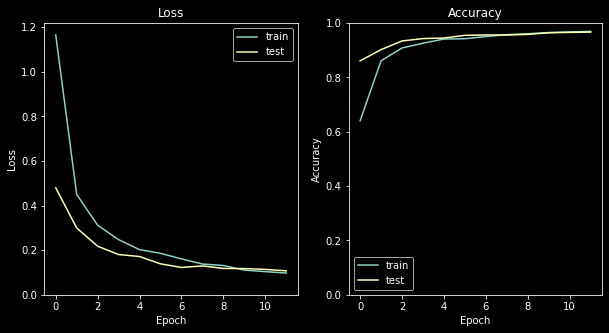

In [45]:
def plot_history(history, validation=False):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharex=True)
    #fig.tight_layout()
    # plot history for loss
    ax[0].plot(history.history['loss'])
    if validation:
        ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_ylim(bottom=0.)
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['train', 'test'])
    
    # plot history for F score etc.
    ax[1].plot(history.history['accuracy'])
    if validation:
        ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Accuracy')
    ax[1].set_ylim(bottom=0., top=1.0)
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['train', 'test'])

plot_history(history, validation=True)

# Predict unseen examples


In [46]:
num=36
import time
start = time.time()
y_pred = model.predict(X_test[:num], verbose=1, batch_size=12)
end = time.time()
print('Exec time per prediction = {:.3f}'.format((end-start)/num))

1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 17ms/step


Exec time per prediction = 0.005


Predictions are returned as vectors in one-hot encoding. Or rather, they are the activations of the last layer in the NN.

To convert them back to class numbers (0-9), we want to get the index of the output neuron with the highest activation using `argmax`.

In [47]:
Y_pred = np.argmax(y_pred, axis=1)


6


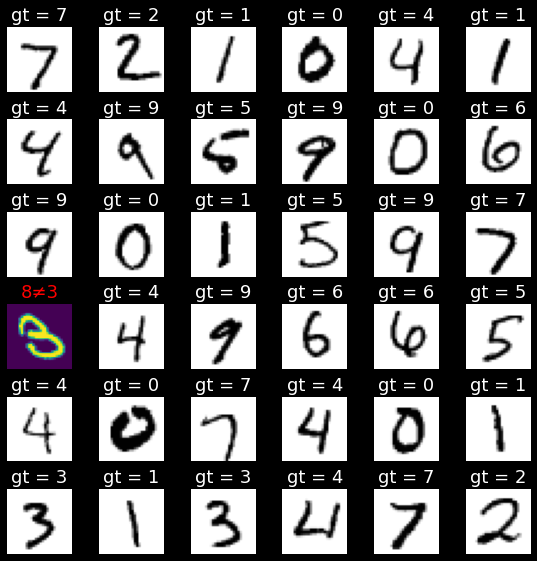

In [48]:
plot_images(X_test[:num], Y_pred, gt=y_test[:num])


# Take-Aways

- 

# Further Reading

- recap optimizers in the excellent blog post on [ruder.io](https://ruder.io/optimizing-gradient-descent/) and an intuition on their use
